In [127]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
import torch
import numpy as np
import pandas as pd
import shap
from copy import deepcopy
from pathlib import Path
import lightning.pytorch as pl
from chemprop import data, models
from chemprop.featurizers.atom import SHAPMultiHotAtomFeaturizer
from chemprop.featurizers.bond import SHAPMultiHotBondFeaturizer
import os
from habnet.featuriser.featurise import Featuriser, MOL_TYPES
from habnet.featuriser.habnet_featurizer import AtomHAbNetFeaturizer
from chemprop import data, featurizers, nn
from chemprop.nn import metrics
from chemprop.models import multi
from chemprop.nn.metrics import MSE
from lightning import pytorch as pl
# Import dependencies and classes
import sys

from copy import deepcopy
from lightning import pytorch as pl
from pathlib import Path

import pandas as pd
import numpy as np
import torch

from dataclasses import InitVar, dataclass
from typing import List, Sequence, Tuple, Union, Optional
from rdkit import Chem
from rdkit.Chem import Mol, Draw
from rdkit.Chem.rdchem import Atom, Bond, BondType

from chemprop.featurizers.atom import MultiHotAtomFeaturizer
from chemprop.featurizers.bond import MultiHotBondFeaturizer
from chemprop.featurizers.molgraph.molecule import SimpleMoleculeMolGraphFeaturizer

from chemprop.data.molgraph import MolGraph
from chemprop.featurizers.base import GraphFeaturizer
from chemprop.featurizers.molgraph.mixins import _MolGraphFeaturizerMixin

from chemprop import data, featurizers, models

import shap # do "pip install shap" if you don't have it installed

import logging

# Set logging level to WARNING to suppress INFO logs
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)

In [3]:
ckpt_path = "/home/calvin/code/chemprop_original/lightning_logs/version_0/checkpoints/epoch=49-val_rmse=0.00-BEST.ckpt"


In [4]:
feat_data = Featuriser(os.path.expanduser("~/code/chemprop_phd_customised/habnet/data/processed/sdf_data"), path = "/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data.csv",
                       include_extra_features = True)
def leave_one_out_split(feat_data, n_leave_out: int =1):
    """
    Given feat_data structured as [list_of_r1h, list_of_r2h],
    this function returns a list of tuples (train, test) for each leave-one-out split.
    Each train is a list of two lists (for r1h and r2h) with one element left out,
    and each test is a list of two lists containing the left-out element.
    """
    n = len(feat_data[0])  # assuming both lists have the same length
    feat_data_mod = []
    leave_out = []
    leave_out.append([feat_data[0][-n_leave_out]])
    leave_out.append([feat_data[1][-n_leave_out]])
    feat_data_mod.append(feat_data[0][:-n_leave_out])
    feat_data_mod.append(feat_data[1][:-n_leave_out])

    return feat_data_mod, leave_out

feat_data_mod, leave_one_out = leave_one_out_split(feat_data)


Reaction rxn_635 not found in target data
Reaction rxn_288 not found in target data
Reaction rxn_785 not found in target data


In [5]:
component_to_split_by = 0
mols = [d.mol for d in feat_data_mod[component_to_split_by]]

train_indices, val_indices, test_indices = data.make_split_indices(mols, "kennard_stone", (0.8, 0.1, 0.1))


train_data, val_data, test_data = data.split_data_by_indices(
    feat_data_mod, train_indices, val_indices, test_indices
)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [1]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer(
    extra_atom_fdim=13
)

train_datasets = [data.MoleculeDataset(train_data[0][i], featurizer) for i in range(len(MOL_TYPES))]
val_datasets = [data.MoleculeDataset(val_data[0][i], featurizer) for i in range(len(MOL_TYPES))]
test_datasets = [data.MoleculeDataset(test_data[0][i], featurizer) for i in range(len(MOL_TYPES))]

NameError: name 'featurizers' is not defined

In [2]:
train_mcdset = data.MulticomponentDataset(train_datasets)
scaler = train_mcdset.normalize_targets()
val_mcdset = data.MulticomponentDataset(val_datasets)
val_mcdset.normalize_targets(scaler)
test_mcdset = data.MulticomponentDataset(test_datasets)

NameError: name 'data' is not defined

In [3]:
train_loader = data.build_dataloader(train_mcdset, batch_size=64)
val_loader = data.build_dataloader(val_mcdset, shuffle=False, batch_size=64)
test_loader = data.build_dataloader(test_mcdset, shuffle=False, batch_size=64)

NameError: name 'data' is not defined

In [9]:
leave_one_out_mcdset = data.MulticomponentDataset(leave_one_out)

In [10]:
n_atom_features = 8
n_bond_features = 4

In [11]:
keep_atom_features = [True]*n_atom_features
keep_bond_features = [True]*n_bond_features

In [12]:
model = models.MulticomponentMPNN.load_from_checkpoint(ckpt_path)
model.eval()

MulticomponentMPNN(
  (message_passing): MulticomponentMessagePassing(
    (blocks): ModuleList(
      (0-1): 2 x BondMessagePassing(
        (W_i): Linear(in_features=96, out_features=300, bias=False)
        (W_h): Linear(in_features=300, out_features=300, bias=False)
        (W_o): Linear(in_features=382, out_features=300, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (tau): ReLU()
        (V_d_transform): Identity()
        (graph_transform): Identity()
      )
    )
  )
  (agg): MeanAggregation()
  (bn): Identity()
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=600, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=300, out_features=5, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0, 1.0, 1.0, 1.0, 1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (me

In [184]:
@dataclass
class CustomSimpleMoleculeMolGraphFeaturizer(SimpleMoleculeMolGraphFeaturizer):
    """A custom SimpleMoleculeMolGraphFeaturizer with additional feature control."""

    keep_atom_features: Optional[List[bool]] = None
    keep_bond_features: Optional[List[bool]] = None
    keep_atoms: Optional[List[bool]] = None
    keep_bonds: Optional[List[bool]] = None
    keep_atom_features_extra: Optional[List[bool]] = None  # NEW

    def __post_init__(self, extra_atom_fdim: int = 0, extra_bond_fdim: int = 0):
        super().__post_init__(extra_atom_fdim, extra_bond_fdim)

        if isinstance(self.atom_featurizer, SHAPMultiHotAtomFeaturizer) and self.keep_atom_features is not None:
            self.atom_featurizer.keep_features = self.keep_atom_features
        if isinstance(self.bond_featurizer, SHAPMultiHotBondFeaturizer) and self.keep_bond_features is not None:
            self.bond_featurizer.keep_features = self.keep_bond_features

    def __call__(
        self,
        mol: Chem.Mol,
        atom_features_extra: np.ndarray | None = None,
        bond_features_extra: np.ndarray | None = None,
    ) -> MolGraph:
        n_atoms = mol.GetNumAtoms()
        n_bonds = mol.GetNumBonds()

        keep_atoms = [True] * n_atoms if self.keep_atoms is None else self.keep_atoms
        keep_bonds = [True] * n_bonds if self.keep_bonds is None else self.keep_bonds

        if atom_features_extra is not None and len(atom_features_extra) != n_atoms:
            raise ValueError(
                "Input molecule must have same number of atoms as `len(atom_features_extra)`!"
                f"got: {n_atoms} and {len(atom_features_extra)}, respectively"
            )
        if bond_features_extra is not None and len(bond_features_extra) != n_bonds:
            raise ValueError(
                "Input molecule must have same number of bonds as `len(bond_features_extra)`!"
                f"got: {n_bonds} and {len(bond_features_extra)}, respectively"
            )

        # ===== Atom Features =====
        if n_atoms == 0:
            V = np.zeros((1, self.atom_fdim), dtype=np.single)
        else:
            V = np.array([self.atom_featurizer(a) if keep_atoms[a.GetIdx()] else self.atom_featurizer.zero_mask()
                          for a in mol.GetAtoms()], dtype=np.single)

        # ===== Extra Atom Features with Masking =====
        if atom_features_extra is not None:
            if self.keep_atom_features_extra is not None:
                processed_mask = self.process_extra_feature_mask(self.keep_atom_features_extra)
                processed_mask = np.array(processed_mask, dtype=np.float32)
                processed_mask = np.expand_dims(processed_mask, axis=0)  # Shape (1, 10)
                # print(f"processed_mask: {processed_mask}")
                # print(f"atom_features_extra: {atom_features_extra}")
                masked_extra = atom_features_extra * processed_mask
            else:
                masked_extra = atom_features_extra
            V = np.hstack((V, masked_extra))

        # ===== Bonds =====
        E = np.empty((2 * n_bonds, self.bond_fdim))
        edge_index = [[], []]

        i = 0
        for u in range(n_atoms):
            for v in range(u + 1, n_atoms):
                bond = mol.GetBondBetweenAtoms(u, v)
                if bond is None:
                    continue

                x_e = self.bond_featurizer(bond) if keep_bonds[bond.GetIdx()] else self.bond_featurizer.zero_mask()

                if bond_features_extra is not None:
                    x_e = np.concatenate((x_e, bond_features_extra[bond.GetIdx()]), dtype=np.single)

                E[i: i + 2] = x_e
                edge_index[0].extend([u, v])
                edge_index[1].extend([v, u])
                i += 2

        rev_edge_index = np.arange(len(E)).reshape(-1, 2)[:, ::-1].ravel()
        edge_index = np.array(edge_index, int)
        return MolGraph(V, E, edge_index, rev_edge_index)

    def process_extra_feature_mask(self, mask):
        """
        Processes the extra atom feature mask:
        Columns 0,1,2,3 are binary and can be masked independently.
        Columns 4-5, 6-7, 8-9 are coupled.
        If indicator (odd index) is 0, the value (even index) is also masked.
        """
        processed_mask = mask.copy()
        for i in range(4, 9, 2):
            indicator_idx = i + 1
            value_idx = i
            if processed_mask[indicator_idx] == 0:
                processed_mask[value_idx] = 0
        return processed_mask


In [ ]:
test_mcdset = data.MulticomponentDataset(leave_one_out)

[MoleculeDataset(data=[MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x71add28eca50>, y=[1.2745150822031035, 1.280622840533244, 171.3455136972803, 342.41827372979765, 2.8107398161022217], weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='rmg_rxn_323_r1h', V_f=array([[  1.       ,   0.       ,   0.       ,   0.       ,   0.       ,
           0.       ,   0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ,   1.5241743,
           1.       , 103.06803  ,   1.       ,  34.786175 ,   1.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ,   3.685307 ,
           1.       ,  18.92838  ,   1.       , 349.8281   ,   1.       ],
        [  0.       ,   0.       ,   1.       ,   0.       ,   0.8      ,
           1.       ,   0.       ,   0.       ,   0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       ,   0.       ,   1.3628916,
           1.       , 106.687584 ,   1.   

In [285]:
# ===== Helper Function =====
def get_predictions(keep_atom_features_list, keep_bond_features_list, keep_atom_extras, smi_pair, passing_batch):
    # print(f"keep_atom_features: {keep_atom_features_list}")
    # print(f"keep_bond_features: {keep_bond_features_list}")
    featurizer = CustomSimpleMoleculeMolGraphFeaturizer(
        atom_featurizer=SHAPMultiHotAtomFeaturizer.v2(),
        bond_featurizer=SHAPMultiHotBondFeaturizer(),
        keep_atom_features=keep_atom_features_list,
        keep_bond_features=keep_bond_features_list,
        keep_atom_features_extra=keep_atom_extras,
    )
    #datapoint = [smi_pair]
    
    if passing_batch:
        dataset = [data.MoleculeDataset([smi_pair[i]], featurizer) for i in range(len(MOL_TYPES))]
    else:
        datapoint = [smi_pair]
        dataset = [data.MoleculeDataset(datapoint[0][i], featurizer) for i in range(len(MOL_TYPES))]
    dataset = data.MulticomponentDataset(dataset)
    # print(dataset)
    dataloader = data.build_dataloader(dataset, shuffle=False, batch_size=1)

    trainer = pl.Trainer(logger=False, enable_progress_bar=False, accelerator="cpu", devices=1)
    with torch.inference_mode():
        preds = trainer.predict(model, dataloader)

    return preds[0][0].cpu().numpy()

In [286]:
get_predictions(
    keep_atom_features_list=keep_atom_features,
    keep_bond_features_list=keep_bond_features,
    smi_pair=leave_one_out,
    keep_atom_extras=[True, True, True, True, True, True, True, True, True, True],
    passing_batch=False
)

/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


array([  1.3708234,   1.521067 , 173.89761  ,  74.2549   ,   9.932358 ],
      dtype=float32)

In [287]:
class MulticomponentModelWrapper:
    def __init__(self, mol_datapoints, passing_batch=False):
        self.mol_datapoints = mol_datapoints
        self.passing_batch = passing_batch

    def __call__(self, X):
        preds = []
        for keep_features in X:
            n_atom_features = 8
            n_bond_features = 4
            n_atom_extras = 10  # your extra features

            keep_atom_features = keep_features[:n_atom_features].astype(bool).tolist()
            keep_bond_features = keep_features[n_atom_features:n_atom_features + n_bond_features].astype(bool).tolist()
            keep_atom_extras = keep_features[n_atom_features + n_bond_features:n_atom_features + n_bond_features + n_atom_extras].astype(bool).tolist()

            pred = get_predictions(
                keep_atom_features_list=keep_atom_features,
                keep_bond_features_list=keep_bond_features,
                smi_pair=self.mol_datapoints,
                keep_atom_extras=keep_atom_extras,
                passing_batch=self.passing_batch  # Now correct length
            )
            preds.append(pred)
        return np.array(preds)


In [288]:
model_wrapper = MulticomponentModelWrapper(test_data)

In [289]:
def combined_binary_masker(binary_mask, x):
    # Ensure both are 2D
    binary_mask = np.atleast_2d(binary_mask)
    x = np.atleast_2d(x)

    masked_x = deepcopy(x)

    # Mask atom + bond features (first 12)
    masked_x[:, :12] *= binary_mask[:, :12]

    # Mask extra atom features (first 4) independently
    masked_x[:, 12:16] *= binary_mask[:, 12:16]

    # Apply structured dependency mask for pairs
    for pair_start, indicator_col in [(16, 17), (18, 19), (20, 21)]:
        indicator = binary_mask[:, indicator_col]
        masked_x[:, pair_start] *= indicator
        masked_x[:, indicator_col] *= indicator

    return masked_x


In [290]:
v = reactions_list[0]
print(v)
m = [data.MoleculeDataset([v[i]], featurizer) for i in range(len(MOL_TYPES))]
multicomponent_dataset = data.MulticomponentDataset(m)
# load into loader
load = data.build_dataloader(multicomponent_dataset, batch_size=1)

[MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x71add28eca50>, y=[1.2745150822031035, 1.280622840533244, 171.3455136972803, 342.41827372979765, 2.8107398161022217], weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='rmg_rxn_323_r1h', V_f=array([[  1.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ,   1.5241743,
          1.       , 103.06803  ,   1.       ,  34.786175 ,   1.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ,   3.685307 ,
          1.       ,  18.92838  ,   1.       , 349.8281   ,   1.       ],
       [  0.       ,   0.       ,   1.       ,   0.       ,   0.8      ,
          1.       ,   0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ,   1.3628916,
          1.       , 106.687584 ,   1.       ,   0.       ,   0.       ]

In [291]:
load

In [292]:
# FOR ONE DATAPOINT

# keep_features = np.ones((1, 22))  # (1, total_features)
# # Atom features: 8 -> atomic_mass
# # Change the first value to 0 to mask the first feature
# pred = model_wrapper(keep_features)
# # print(pred)

# explainer = shap.PermutationExplainer(model_wrapper, masker=combined_binary_masker)
# explanation = explainer(keep_features, max_evals=100)

reactions_list = [[test_data[0][0][i], test_data[0][1][i]] for i in range(len(test_data[0][0]))]

# FOR MULTIPLE DATAPOINTS - 182
keep_features = np.ones((182, 22))  # (182, total_features)
# # Atom features: 8 -> atomic_mass
all_explanations = []

# For each reaction
for i, reaction in enumerate(reactions_list):
    print(f"🔍 Explaining Reaction {i+1}/{len(reactions_list)}")

    # 1. Make wrapper for this reaction
    model_wrapper = MulticomponentModelWrapper(reaction, passing_batch=True)

    # 2. Define all features as present (1)
    keep_features = np.ones((1, 22))

    # 3. SHAP explainer
    explainer = shap.PermutationExplainer(model_wrapper, masker=combined_binary_masker)
    explanation = explainer(keep_features, max_evals=100)

    # 4. Store
    all_explanations.append(explanation)


🔍 Explaining Reaction 1/182
🔍 Explaining Reaction 2/182
🔍 Explaining Reaction 3/182
🔍 Explaining Reaction 4/182
🔍 Explaining Reaction 5/182
🔍 Explaining Reaction 6/182
🔍 Explaining Reaction 7/182
🔍 Explaining Reaction 8/182
🔍 Explaining Reaction 9/182
🔍 Explaining Reaction 10/182
🔍 Explaining Reaction 11/182
🔍 Explaining Reaction 12/182
🔍 Explaining Reaction 13/182
🔍 Explaining Reaction 14/182
🔍 Explaining Reaction 15/182
🔍 Explaining Reaction 16/182
🔍 Explaining Reaction 17/182
🔍 Explaining Reaction 18/182
🔍 Explaining Reaction 19/182
🔍 Explaining Reaction 20/182
🔍 Explaining Reaction 21/182
🔍 Explaining Reaction 22/182
🔍 Explaining Reaction 23/182
🔍 Explaining Reaction 24/182
🔍 Explaining Reaction 25/182
🔍 Explaining Reaction 26/182
🔍 Explaining Reaction 27/182
🔍 Explaining Reaction 28/182
🔍 Explaining Reaction 29/182
🔍 Explaining Reaction 30/182
🔍 Explaining Reaction 31/182
🔍 Explaining Reaction 32/182
🔍 Explaining Reaction 33/182
🔍 Explaining Reaction 34/182
🔍 Explaining Reaction 3

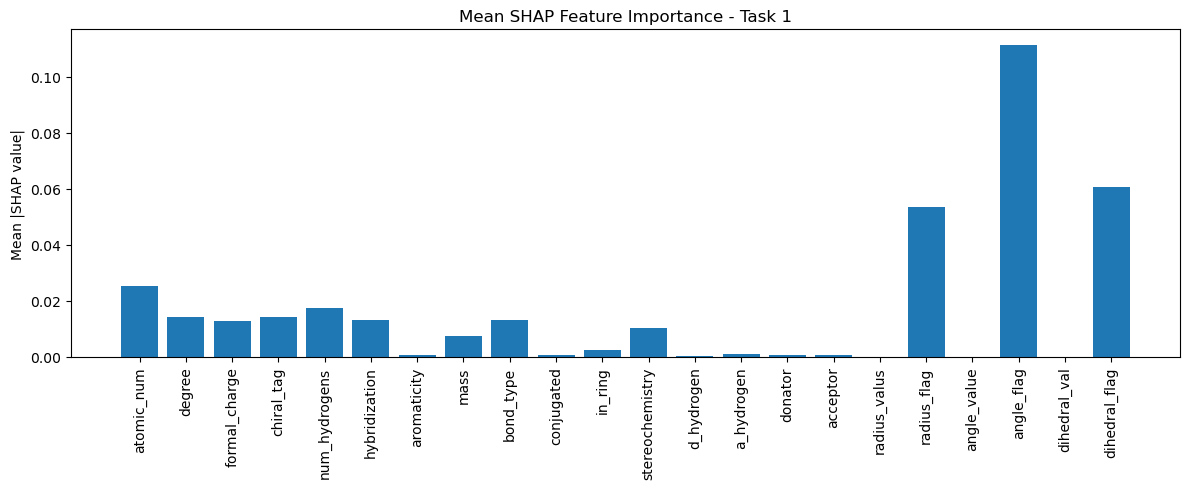

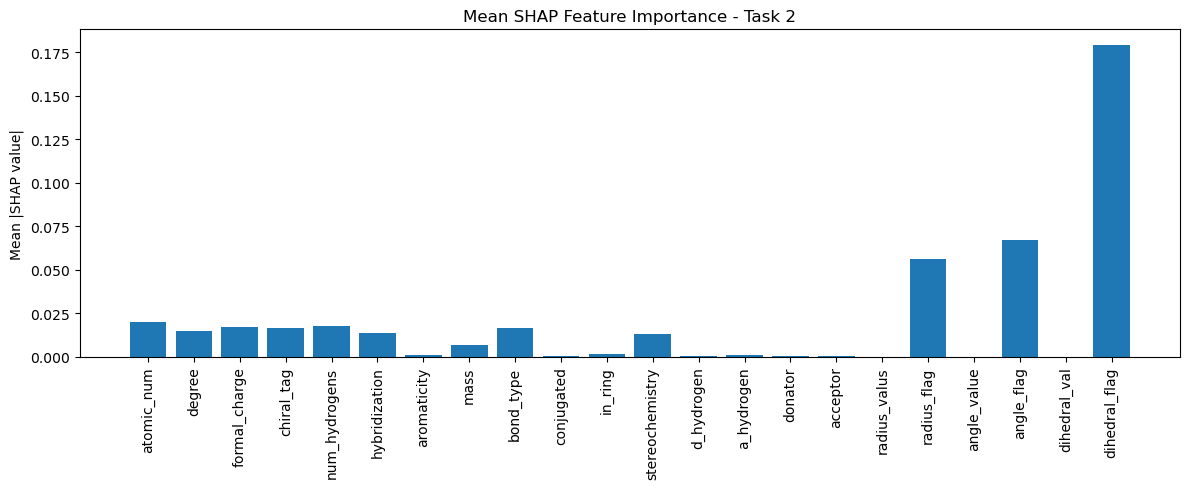

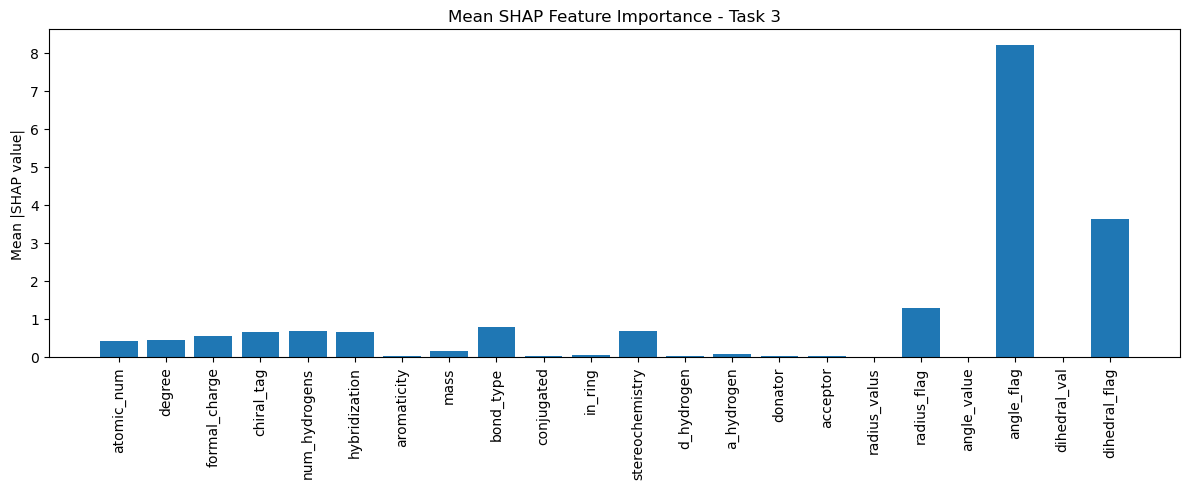

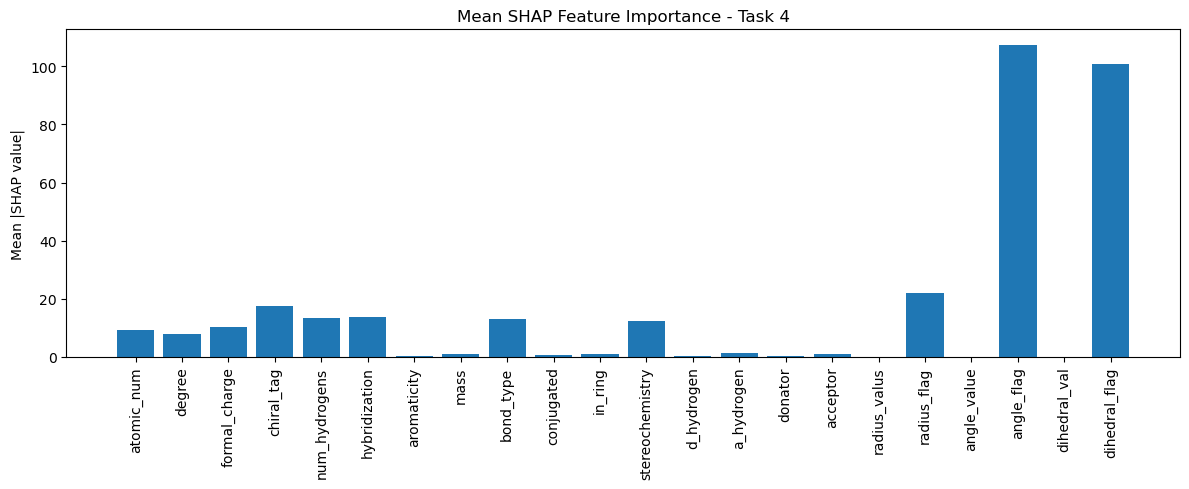

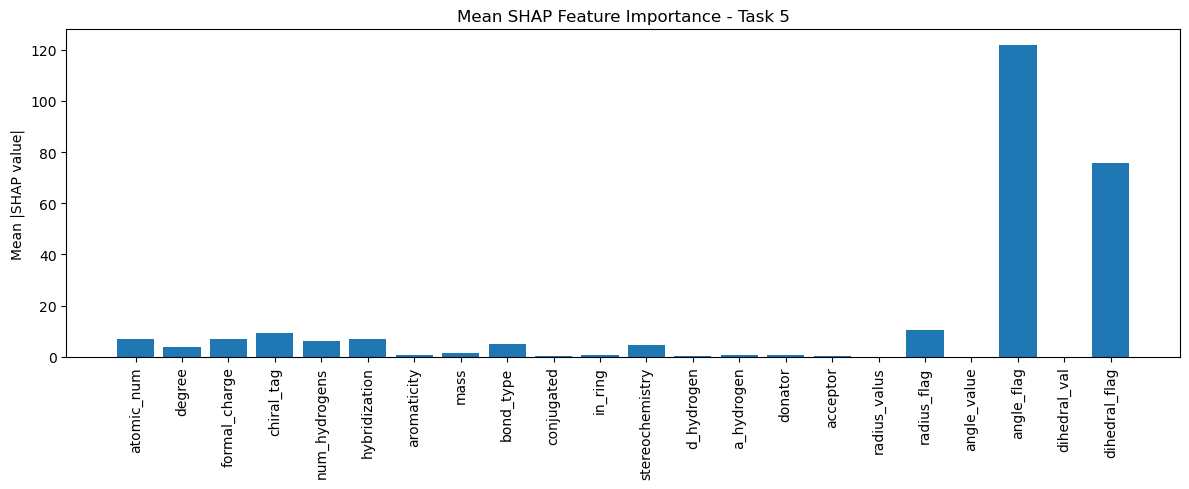

In [300]:
import matplotlib.pyplot as plt
import numpy as np

num_features = all_explanations[0].values.shape[1]
num_tasks = all_explanations[0].values.shape[2]
feature_names = [
    "atomic_num", "degree", "formal_charge", "chiral_tag", "num_hydrogens",
    "hybridization", "aromaticity", "mass", "bond_type", "conjugated", "in_ring",
    "stereochemistry",
    "d_hydrogen", "a_hydrogen",
    "donator", "acceptor",
    "radius_valus", "radius_flag",
    "angle_value", "angle_flag", "dihedral_val", "dihedral_flag"
]
# Initialize
mean_abs_shap = np.zeros((num_features, num_tasks))

# Sum absolute SHAP values
for explanation in all_explanations:
    mean_abs_shap += np.abs(explanation.values[0])  # (features, tasks)

# Average
mean_abs_shap /= len(all_explanations)

# ==== Plotting per task ====
for task_idx in range(num_tasks):
    plt.figure(figsize=(12, 5))
    plt.bar(range(num_features), mean_abs_shap[:, task_idx])
    plt.xticks(range(num_features), feature_names, rotation=90)
    plt.title(f"Mean SHAP Feature Importance - Task {task_idx + 1}")
    plt.ylabel("Mean |SHAP value|")
    plt.tight_layout()
    plt.show()


🔍 Plotting SHAP for Task 1


/tmp/ipykernel_3727984/2312534289.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(combined_exp, show=False, max_display=22)


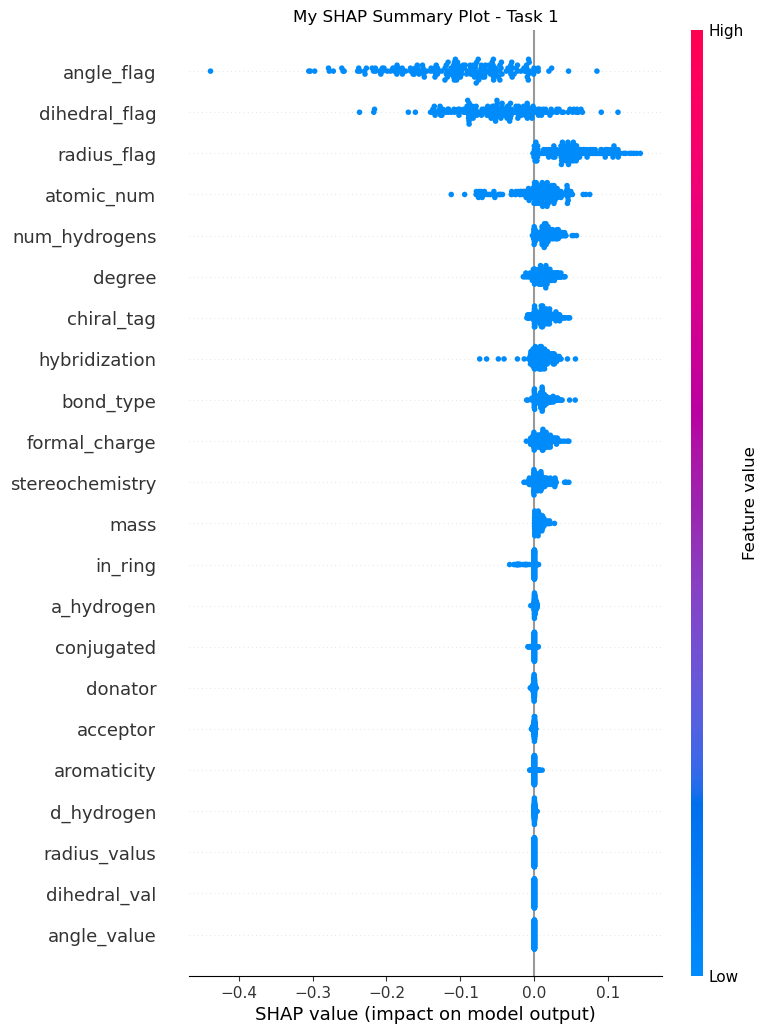

🔍 Plotting SHAP for Task 2


/tmp/ipykernel_3727984/2312534289.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(combined_exp, show=False, max_display=22)


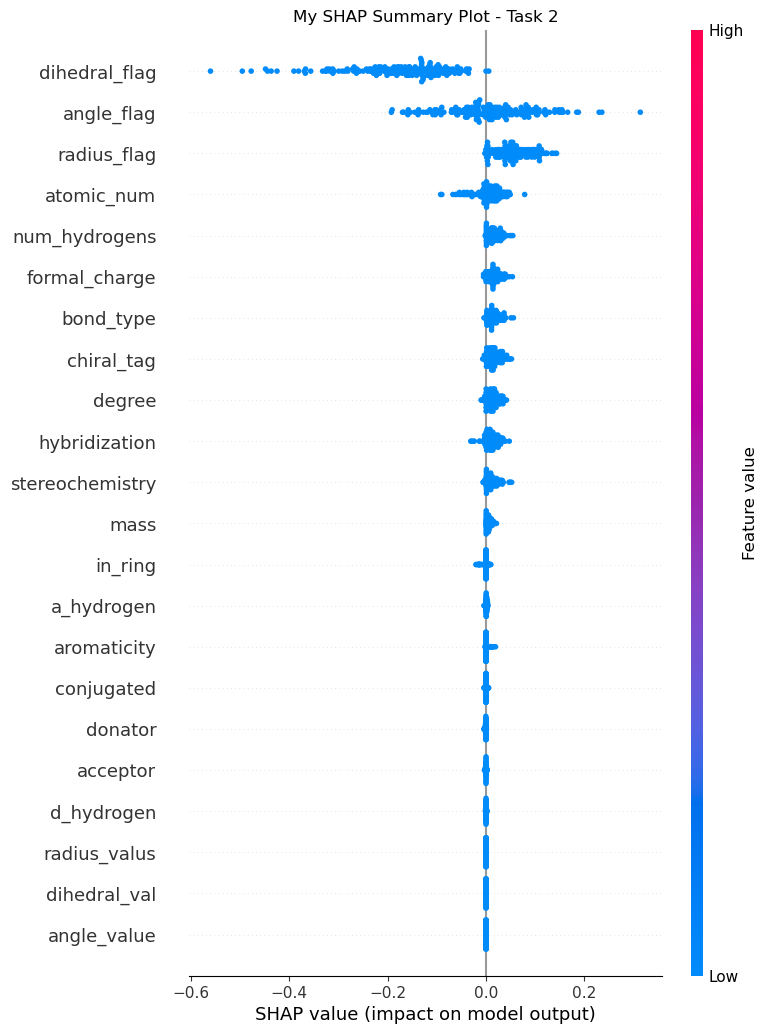

🔍 Plotting SHAP for Task 3


/tmp/ipykernel_3727984/2312534289.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(combined_exp, show=False, max_display=22)


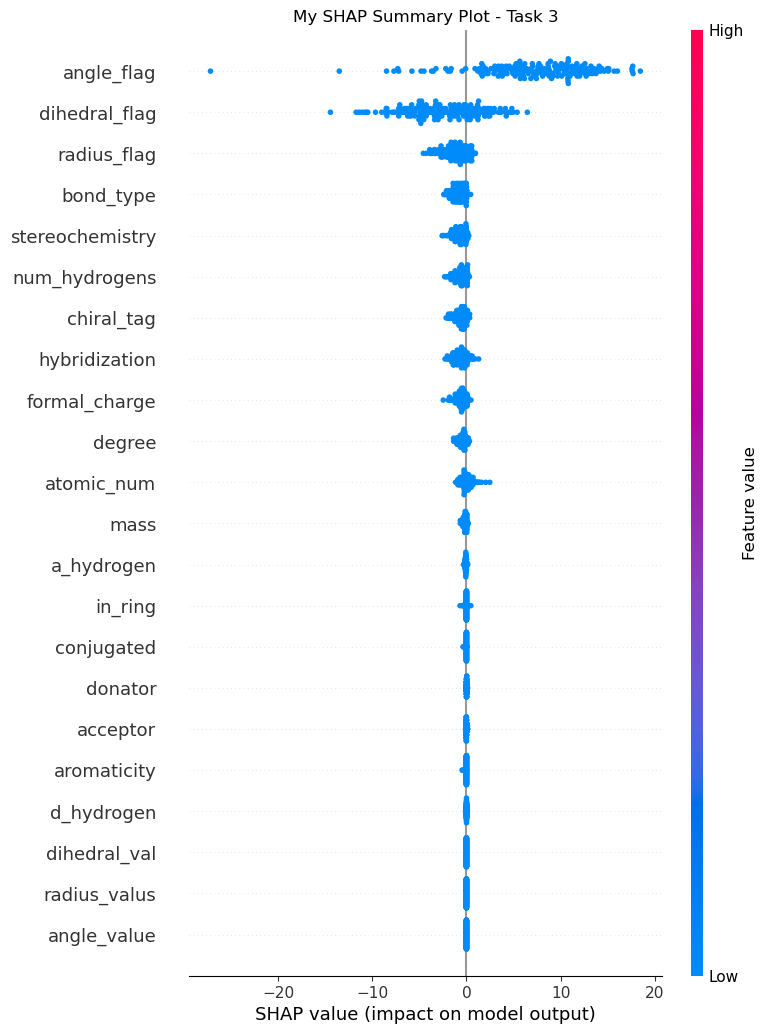

🔍 Plotting SHAP for Task 4


/tmp/ipykernel_3727984/2312534289.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(combined_exp, show=False, max_display=22)


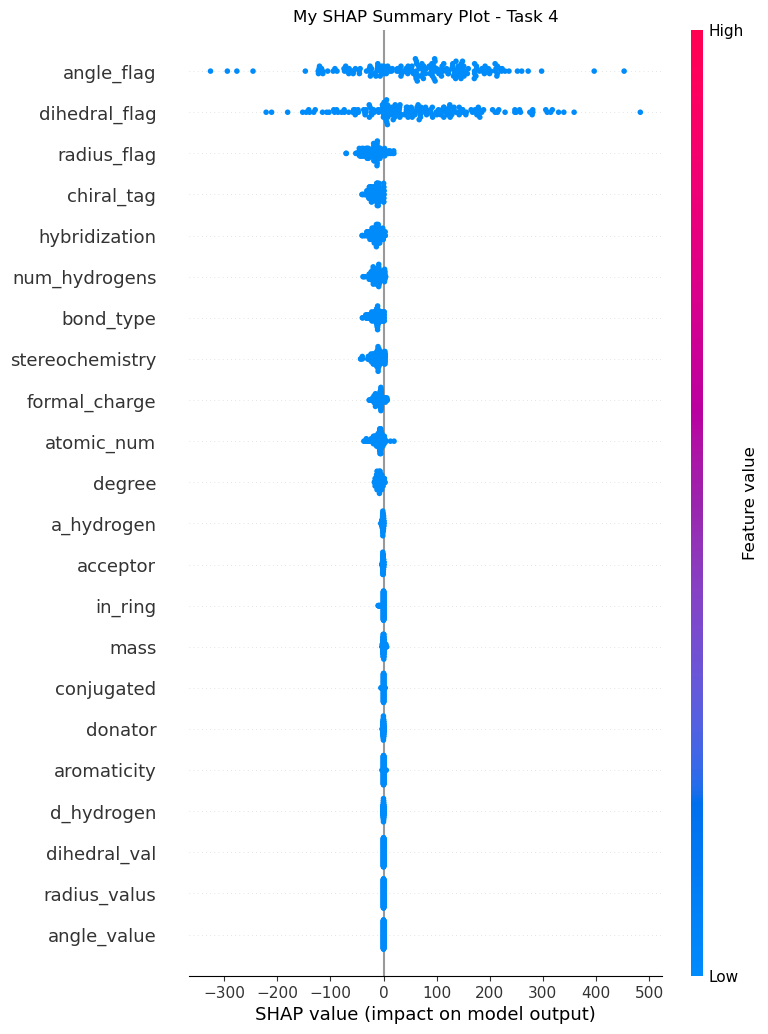

🔍 Plotting SHAP for Task 5


/tmp/ipykernel_3727984/2312534289.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(combined_exp, show=False, max_display=22)


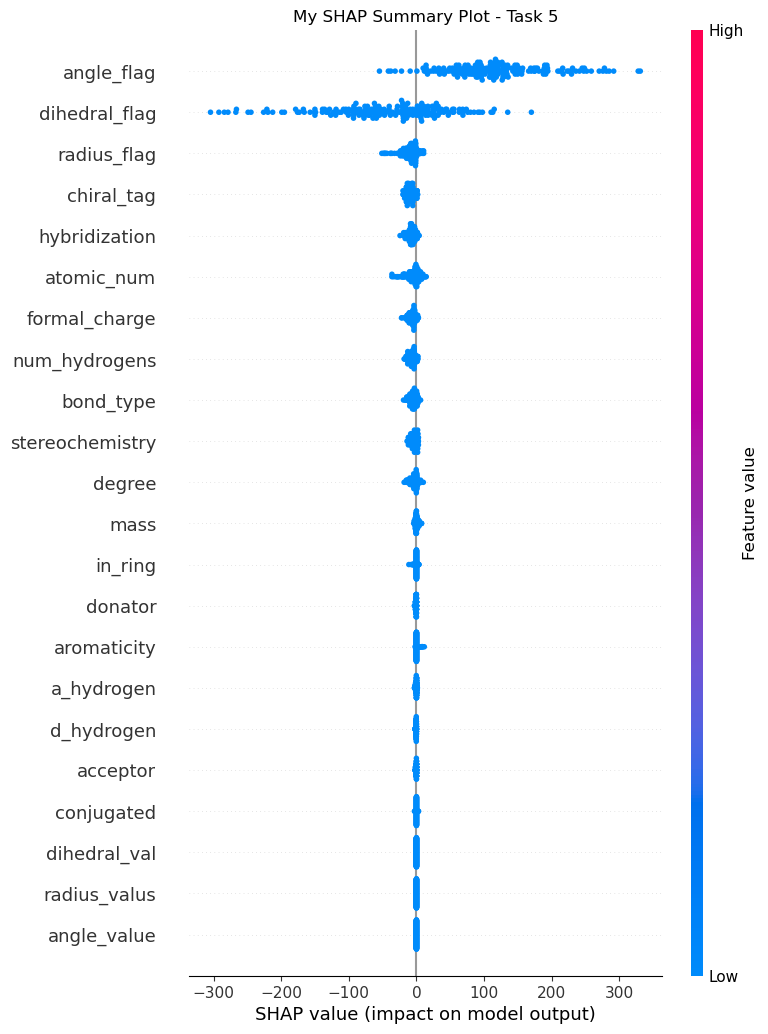

In [307]:
for task_idx in range(num_tasks):
    print(f"🔍 Plotting SHAP for Task {task_idx + 1}")
    
    # Combine SHAP Explanations across reactions
    all_values = np.vstack([exp.values[0][:, task_idx] for exp in all_explanations])  # shape (182, n_features)
    all_data = np.vstack([exp.data[0] for exp in all_explanations])  # shape (182, n_features)

    # Make Explanation
    combined_exp = shap.Explanation(
        values=all_values,
        base_values=np.array([exp.base_values[0, task_idx] for exp in all_explanations]),
        data=all_data,
        feature_names=feature_names
    )
    
    # Plot SHAP summary
    shap.summary_plot(combined_exp, show=False, max_display=22)
    plt.title("My SHAP Summary Plot - Task " + str(task_idx + 1))
    plt.show()


In [ ]:
feature_names = [
    "atomic_num", "degree", "formal_charge", "chiral_tag", "num_hydrogens",
    "hybridization", "aromaticity", "mass", "bond_type", "conjugated", "in_ring",
    "stereochemistry",
    "d_hydrogen", "a_hydrogen",
    "donator", "acceptor",
    "radius_valus", "radius_flag",
    "angle_value", "angle_flag", "dihedral_val", "dihedral_flag"
]
import shap
import matplotlib.pyplot as plt
import numpy as np

def plot_multitask_shap(explanation, feature_names, save_dir=None):
    """
    Plot SHAP feature importances for each task in a multitask setting.

    Args:
        explanation (shap.Explanation): SHAP explanation object.
        feature_names (list): List of feature names.
        save_dir (str, optional): Directory to save plots. If None, plots are shown.
    """
    num_tasks = explanation.values.shape[2]

    for task_idx in range(num_tasks):
        print(f"🔍 Plotting SHAP for Task {task_idx + 1}")

        # Extract for single task
        single_task_expl = shap.Explanation(
            values=explanation.values[0, :, task_idx],
            base_values=explanation.base_values[0, task_idx],
            data=explanation.data[0],
            feature_names=feature_names,
        )

        # Plot
        plt.title(f"Task {task_idx + 1} SHAP Feature Importance")
        shap.plots.bar(single_task_expl, max_display=26)


        # Save or show
        if save_dir is not None:
            plt.savefig(f"{save_dir}/task_{task_idx + 1}_shap.png", bbox_inches="tight")
            plt.close()

🔍 Plotting SHAP for Task 1


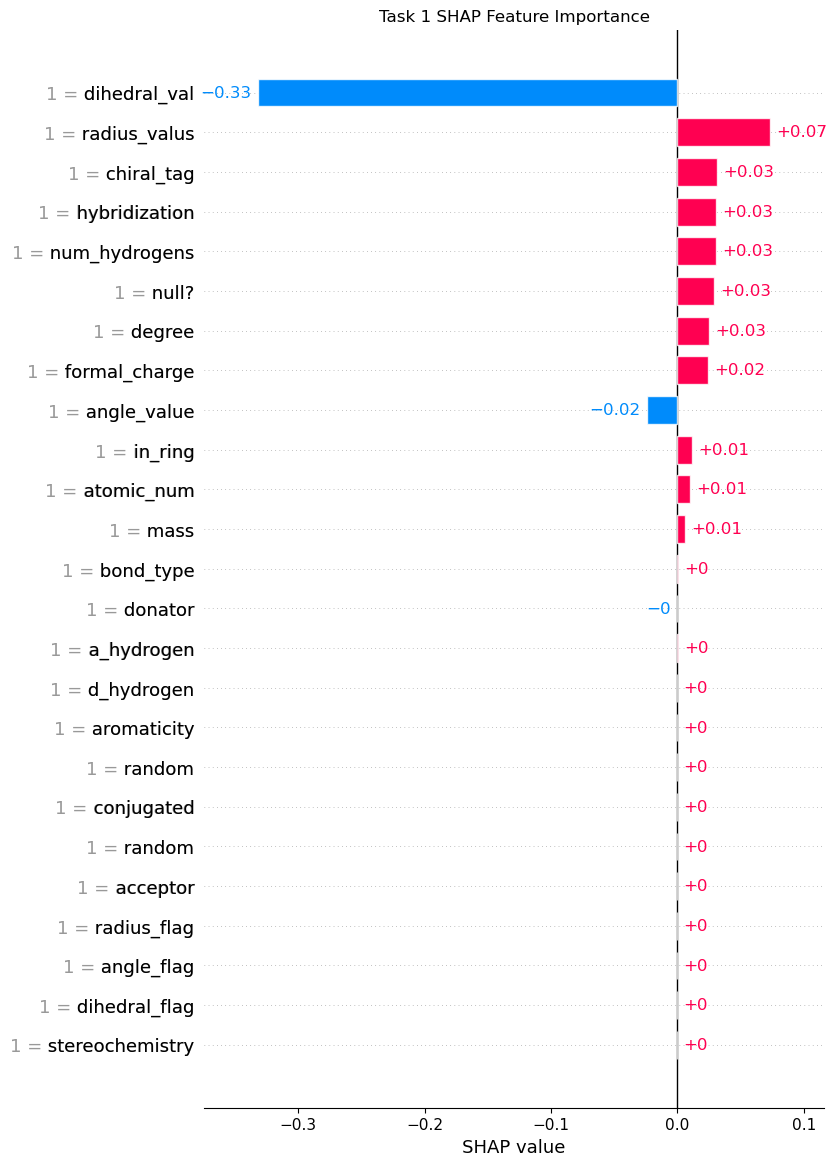

🔍 Plotting SHAP for Task 2


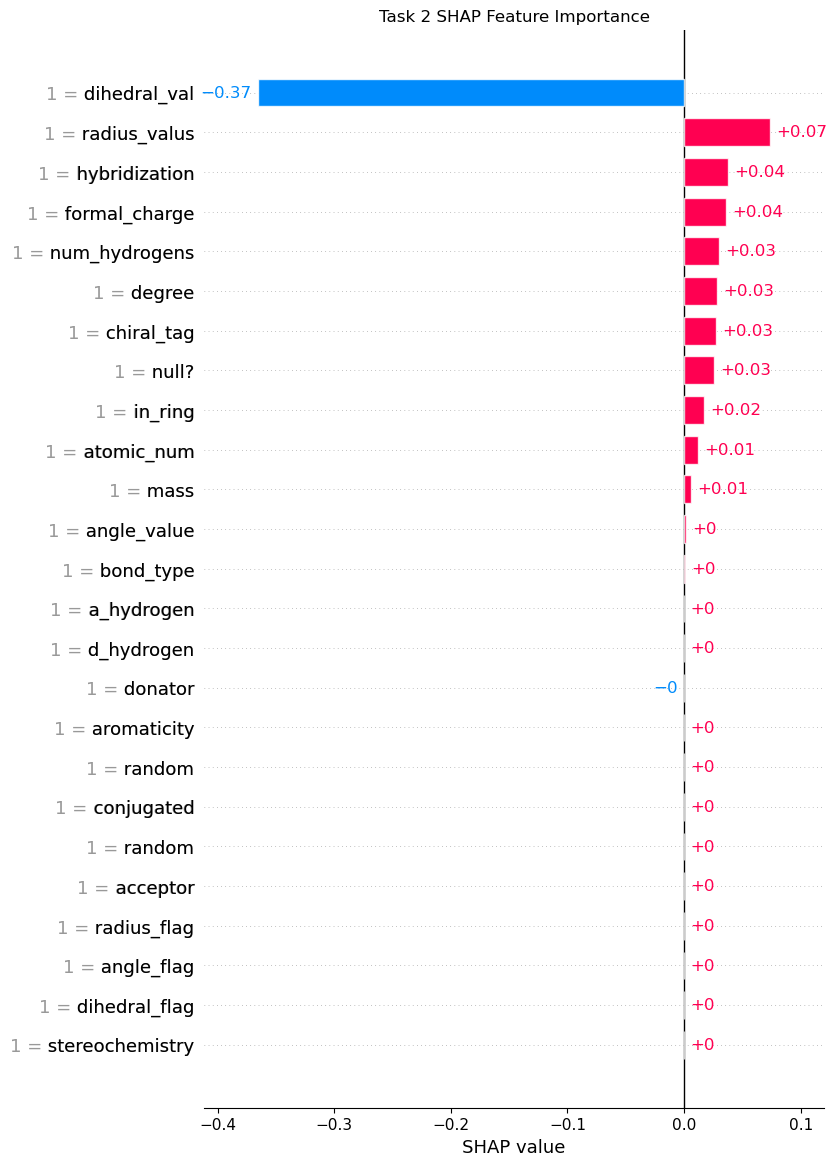

🔍 Plotting SHAP for Task 3


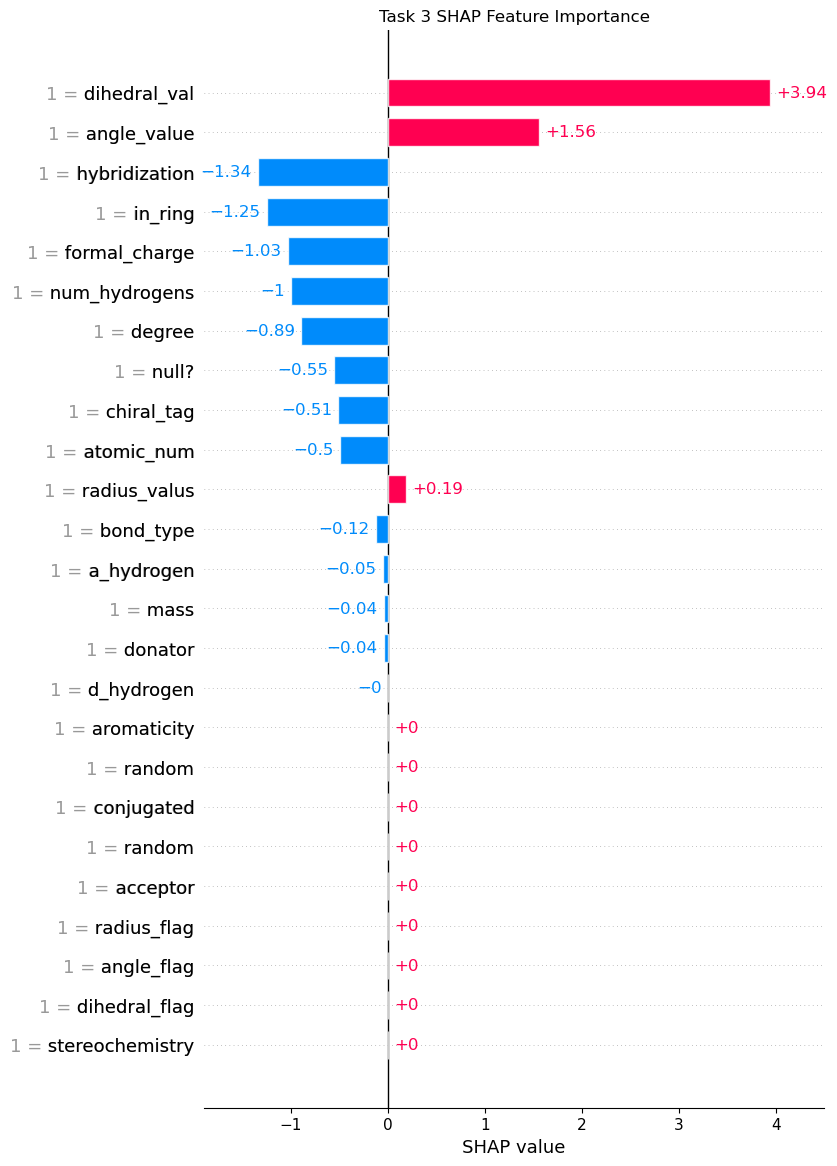

🔍 Plotting SHAP for Task 4


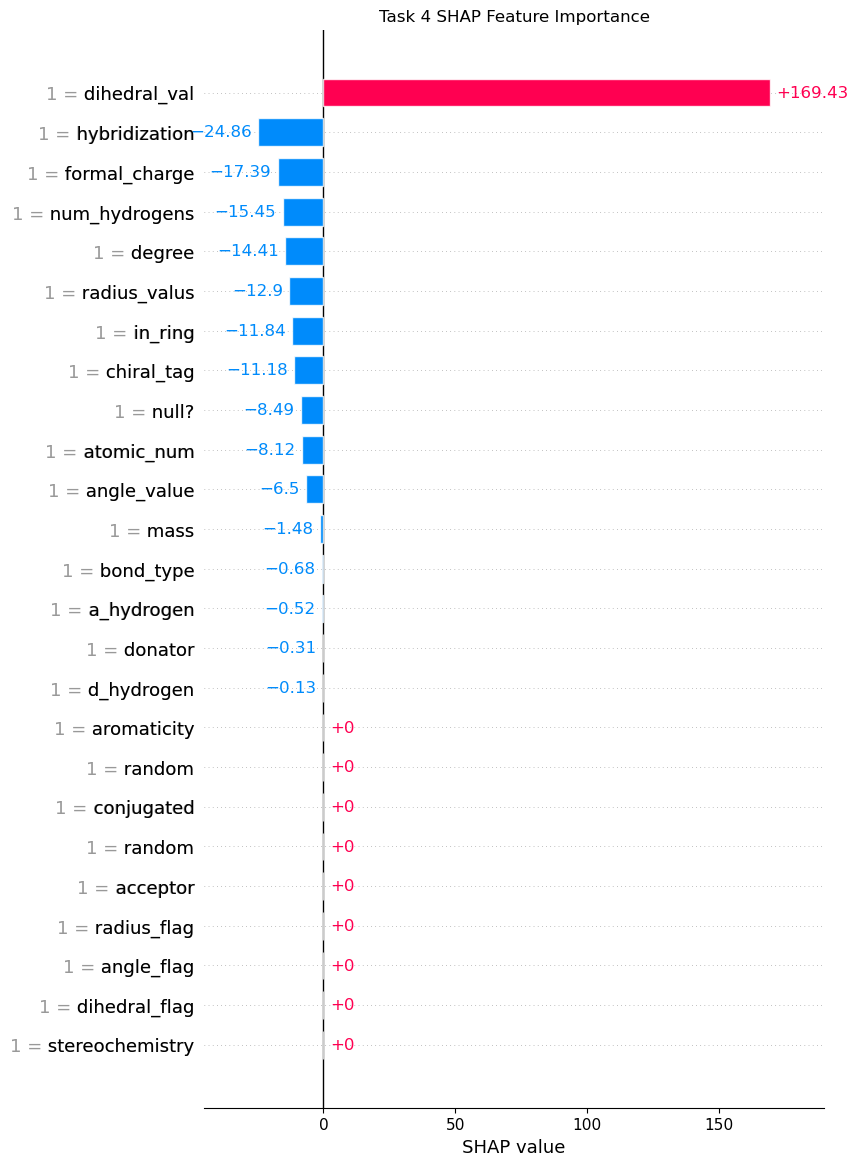

🔍 Plotting SHAP for Task 5


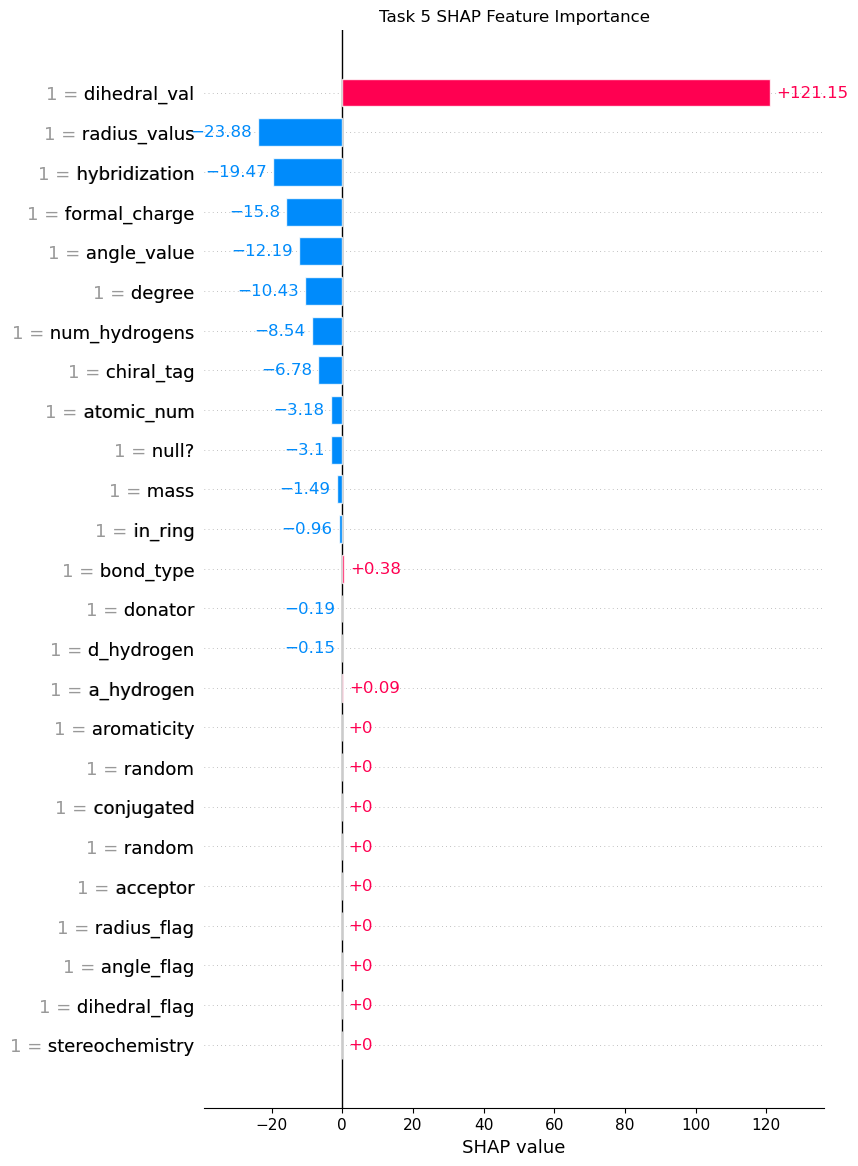

In [183]:
plot_multitask_shap(explanation, feature_names, save_dir=None)

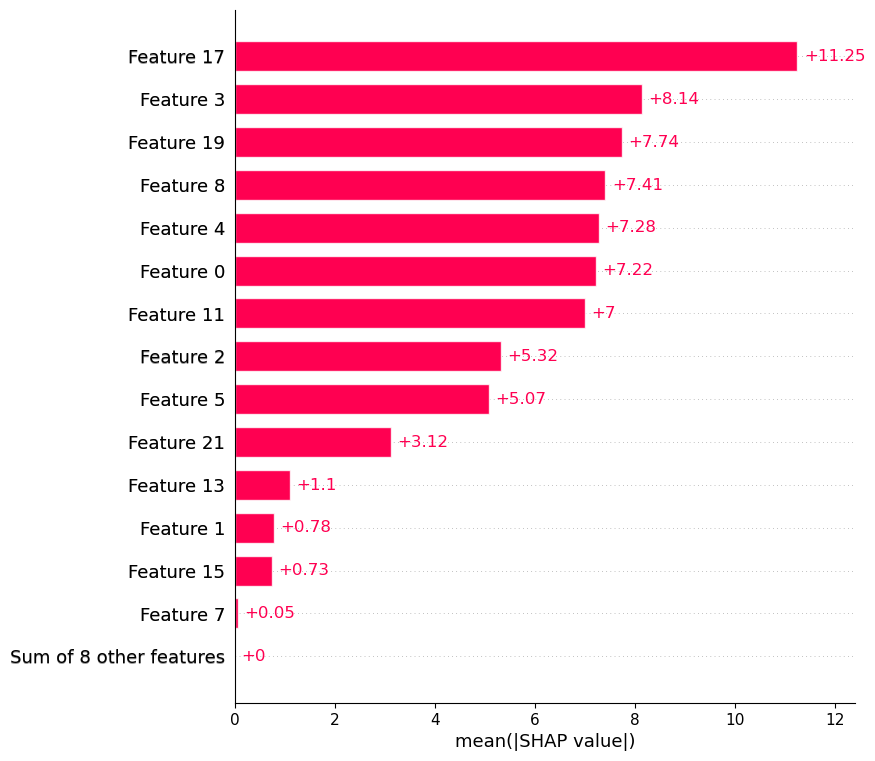

In [81]:
mean_vals = explanation.values.mean(axis=2)  # Average over tasks
mean_expl = shap.Explanation(
    values=mean_vals,
    base_values=explanation.base_values.mean(axis=1),
    data=explanation.data
)

shap.plots.bar(mean_expl, max_display=15)


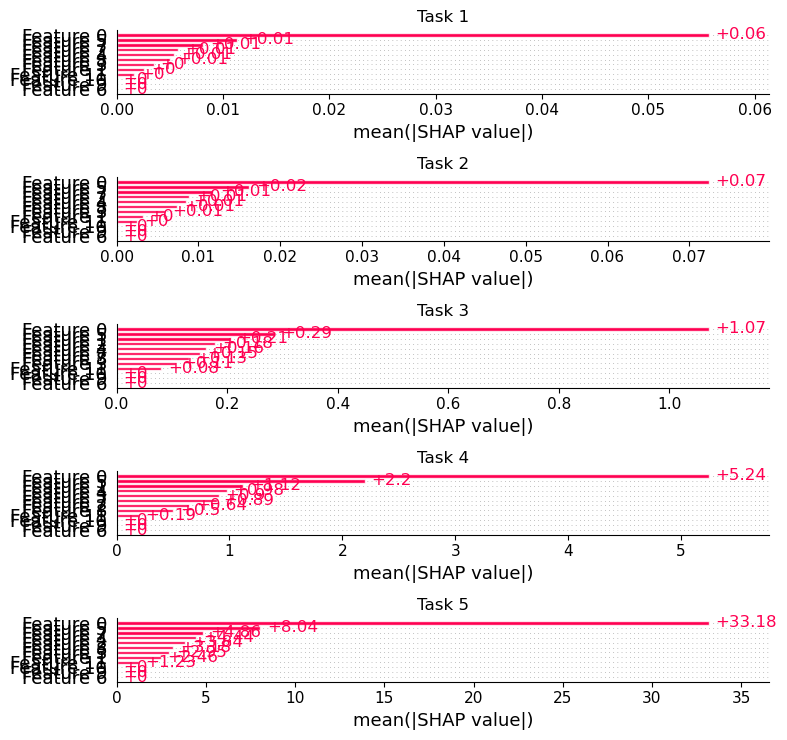

In [219]:
fig, axs = plt.subplots(nrows=num_tasks, figsize=(10, 4 * num_tasks))

for task_idx in range(num_tasks):
    single_task_expl = shap.Explanation(
        values=explanation.values[:, :, task_idx],
        base_values=explanation.base_values[:, task_idx],
        data=explanation.data
    )
    plt.sca(axs[task_idx])
    shap.plots.bar(single_task_expl, max_display=15, show=False)
    axs[task_idx].set_title(f"Task {task_idx + 1}")

plt.tight_layout()
plt.show()
